In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.feature_selection import f_regression
from scipy import stats

In [2]:
data=pd.read_excel('C:/Users/Lenovo/Desktop/1. Predicting Credit Card Spend & Identifying Key Drivers/Data Set.xlsx')
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [4]:
#pandas_profiling.ProfileReport(data).to_file('C:/Users/Lenovo/Desktop/1. Predicting Credit Card Spend & Identifying Key Drivers/profileReport.html')

In [5]:
#Pre-Screening Variables
data.drop(['custid','birthmonth'],axis=1,inplace=True)

In [6]:
def cont_var_summary(x):
    N=x.count()
    Nmiss=x.isna().sum()
    Sum=x.sum()
    Mean=x.mean()
    Median=x.median()
    Std=x.std()
    Var=x.var()
    Min=x.min()
    P1=x.quantile(0.01)
    P5=x.quantile(0.05)
    P10=x.quantile(0.10)
    P25=x.quantile(0.25)
    P50=x.quantile(0.50)
    P75=x.quantile(0.75)
    P90=x.quantile(0.90)
    P95=x.quantile(0.95)
    P99=x.quantile(0.99)
    Max=x.max()
    return pd.Series([N,Nmiss,Sum,Mean,Median,Std,Var,Min,P1,P5,P10,P25,P50,P75,P90,P95,P99,Max],
                     index=['N','NMISS','SUM','MEAN','MEDIAN','STD','VAR','MIN','P1','P5','P10','P25','P50','P75','P90','P95','P99','MAX'])

In [7]:
data.apply(cont_var_summary).to_csv('C:/Users/Lenovo/Desktop/Modelling Case Study Outputs/AuditReport.csv')

In [8]:
#Outlier Analysis
data=data.apply(lambda x: x.clip(lower=x.quantile(0.05),upper=x.quantile(0.95)))

In [9]:
#Missing Value Treatment
data.drop(['lncardten','lnequipten','lntollmon','lnwiremon'],axis=1,inplace=True)
data=data.apply(lambda x: x.fillna(x.mean()))

In [10]:
total_spend=data.cardspent+data.card2spent
data.drop(['cardspent','card2spent'],axis=1,inplace=True)
data['ln_total_spend']=1+np.log(total_spend)

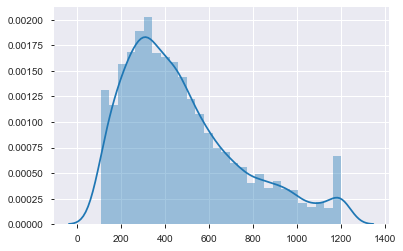

In [11]:
#Checking for normal distribution of dependent variable
sns.distplot(total_spend)
plt.show()

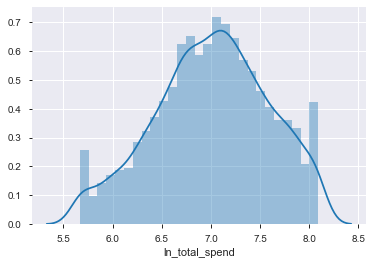

In [12]:
sns.distplot(data.ln_total_spend)
plt.show()

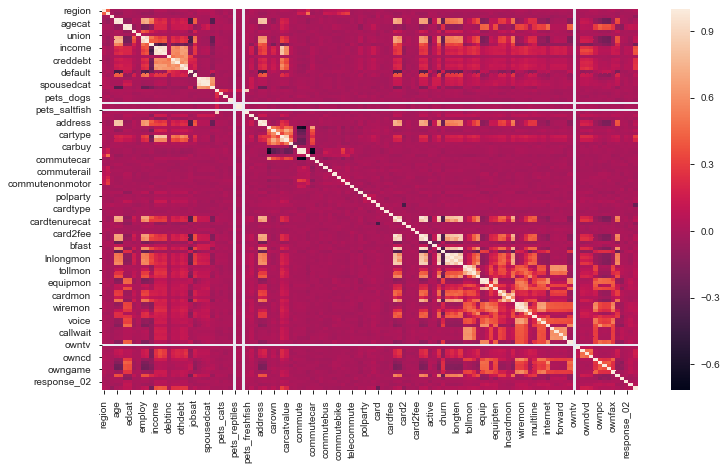

In [13]:
data.corr().to_excel('data_corr.xlsx')
plt.figure(figsize=(12,7))
sns.heatmap(data.corr())
plt.show()

In [14]:
#Removing variables with high correlation with other independent variables
data.drop(['agecat','edcat','empcat','income','inccat',
          'lncreddebt','lnothdebt','marital','spousedcat',
          'pets','addresscat','carcatvalue','commutecat',
          'tenure','card2tenurecat','cardtenurecat','lnlongmon',
          'lnlongten','lntollten','equip','lnequipmon','cardmon',
          'lnwireten'],axis=1,inplace=True)

In [15]:
#Train Test Split
train,test=train_test_split(data,test_size=0.3,random_state=120293)
train_x,test_x,train_y,test_y=train_test_split(data.iloc[:,0:-1],data.ln_total_spend,
                                               test_size=0.3,random_state=120293)

### Linear Regression - OLS

In [16]:
mod_val='ln_total_spend~'+'+'.join(train_x.columns)
mod_val

'ln_total_spend~region+townsize+gender+age+ed+jobcat+union+employ+retire+lninc+debtinc+creddebt+othdebt+default+jobsat+spoused+reside+pets_cats+pets_dogs+pets_birds+pets_reptiles+pets_small+pets_saltfish+pets_freshfish+homeown+hometype+address+cars+carown+cartype+carvalue+carbought+carbuy+commute+commutetime+commutecar+commutemotorcycle+commutecarpool+commutebus+commuterail+commutepublic+commutebike+commutewalk+commutenonmotor+telecommute+reason+polview+polparty+polcontrib+vote+card+cardtype+cardbenefit+cardfee+cardtenure+card2+card2type+card2benefit+card2fee+card2tenure+active+bfast+churn+longmon+longten+tollfree+tollmon+tollten+equipmon+equipten+callcard+lncardmon+cardten+wireless+wiremon+wireten+multline+voice+pager+internet+callid+callwait+forward+confer+ebill+owntv+hourstv+ownvcr+owndvd+owncd+ownpda+ownpc+ownipod+owngame+ownfax+news+response_01+response_02+response_03'

In [17]:
lm1=smf.ols(formula=mod_val,data=train).fit()

In [18]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spend   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     13.94
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          7.50e-179
Time:                        13:53:24   Log-Likelihood:                -2496.2
No. Observations:                3500   AIC:                             5186.
Df Residuals:                    3403   BIC:                             5784.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4235      0.09

In [19]:
# Removing Influential Observations By Cooks'D Method
inf=lm1.get_influence()

In [20]:
cooks_ser=inf.summary_frame().cooks_d

In [21]:
thres=3/len(data)
index_list=[]
for x in cooks_ser:
    if(x>thres):
        index_list.append(cooks_ser[cooks_ser==x].index[0])

In [22]:
len(index_list)

513

In [23]:
train=train.drop(index=index_list)

In [24]:
lm1=smf.ols(formula=mod_val,data=train).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spend   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     24.76
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          3.57e-304
Time:                        13:55:41   Log-Likelihood:                -1231.1
No. Observations:                2987   AIC:                             2656.
Df Residuals:                    2890   BIC:                             3238.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3126      0.07

In [25]:
#F-Regression
f_values,p_values=f_regression(train_x,train_y)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: R

In [26]:
var_ser=pd.Series(train_x.columns)
f_values=pd.Series(f_values).round(2)
p_values=pd.Series(p_values).round(2)
f_regression_res=pd.DataFrame()
f_regression_res=pd.concat([var_ser,f_values,p_values],axis=1)
f_regression_res.columns=['Variable','F-Score','p-Value']
f_regression_res=f_regression_res.sort_values(['p-Value'])
f_regression_res

,Variable,F-Score,p-Value
49,vote,14.47,0.00
50,card,222.13,0.00
54,cardtenure,9.26,0.00
55,card2,29.90,0.00
59,card2tenure,11.40,0.00
65,tollfree,9.31,0.00
66,tollmon,20.96,0.00
67,tollten,36.66,0.00
68,equipmon,14.37,0.00
69,equipten,23.00,0.00


In [27]:
var_ser=f_regression_res[f_regression_res['p-Value']<=0.05].Variable
var_ser=var_ser.astype('str')
var_ser

49           vote
50           card
54     cardtenure
55          card2
59    card2tenure
65       tollfree
66        tollmon
67        tollten
68       equipmon
69       equipten
73       wireless
74        wiremon
75        wireten
77          voice
78          pager
79       internet
80         callid
81       callwait
83         confer
87         ownvcr
88         owndvd
89          owncd
90         ownpda
94         ownfax
30       carvalue
28         carown
98    response_03
14         jobsat
26        address
11       creddebt
9           lninc
8          retire
7          employ
2          gender
4              ed
12        othdebt
24        homeown
97    response_02
92        ownipod
93        owngame
95           news
76       multline
91          ownpc
72        cardten
63        longmon
84          ebill
82        forward
0          region
15        spoused
64        longten
6           union
Name: Variable, dtype: object

In [28]:
mod_val='ln_total_spend~'+'+'.join(var_ser)
mod_val

'ln_total_spend~vote+card+cardtenure+card2+card2tenure+tollfree+tollmon+tollten+equipmon+equipten+wireless+wiremon+wireten+voice+pager+internet+callid+callwait+confer+ownvcr+owndvd+owncd+ownpda+ownfax+carvalue+carown+response_03+jobsat+address+creddebt+lninc+retire+employ+gender+ed+othdebt+homeown+response_02+ownipod+owngame+news+multline+ownpc+cardten+longmon+ebill+forward+region+spoused+longten+union'

In [29]:
lm1=smf.ols(formula=mod_val,data=train).fit()

In [30]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spend   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     44.54
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          1.09e-321
Time:                        13:55:42   Log-Likelihood:                -1271.4
No. Observations:                2987   AIC:                             2647.
Df Residuals:                    2935   BIC:                             2959.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5456      0.089     73.915      

In [31]:
#Variance Inflation Factor
var_ser=pd.Series(train_x.columns)
var_ser=var_ser.drop(index=[0])
mod_val='ln_total_spend~'+'+'.join(var_ser)
a,b=dmatrices(mod_val,train,return_type='dataframe')
vif=pd.DataFrame()
vif['Features']=b.columns
vif['Variance Inflation Factor']=[variance_inflation_factor(b.values,i) for i in range(b.shape[1])]
vif=vif.sort_values(['Variance Inflation Factor'])
vif.head()

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Features,Variance Inflation Factor
0,Intercept,0.000000
85,owntv,0.000000
56,card2type,1.029984
21,pets_small,1.030201
53,cardfee,1.030694


In [32]:
var_ser=vif[vif['Variance Inflation Factor']<=5].Features
var_ser=var_ser.drop(index=[0])
var_ser

85                owntv
56            card2type
21           pets_small
53              cardfee
18            pets_dogs
17            pets_cats
6                 union
36    commutemotorcycle
45               reason
51             cardtype
57         card2benefit
52          cardbenefit
19           pets_birds
23       pets_freshfish
40        commutepublic
2                gender
58             card2fee
47             polparty
97          response_02
86              hourstv
39          commuterail
25             hometype
48           polcontrib
37       commutecarpool
96          response_01
98          response_03
44          telecommute
46              polview
38           commutebus
41          commutebike
            ...        
1              townsize
94               ownfax
76             multline
29              cartype
90               ownpda
31            carbought
4                    ed
15              spoused
84                ebill
91                ownpc
16              

In [33]:
mod_val='ln_total_spend~'+'+'.join(var_ser)
mod_val

'ln_total_spend~owntv+card2type+pets_small+cardfee+pets_dogs+pets_cats+union+commutemotorcycle+reason+cardtype+card2benefit+cardbenefit+pets_birds+pets_freshfish+commutepublic+gender+card2fee+polparty+response_02+hourstv+commuterail+hometype+polcontrib+commutecarpool+response_01+response_03+telecommute+polview+commutebus+commutebike+vote+bfast+carbuy+active+commutenonmotor+homeown+card+commutewalk+card2+churn+commutetime+jobsat+default+owncd+ownipod+owndvd+ownvcr+jobcat+owngame+news+townsize+ownfax+multline+cartype+ownpda+carbought+ed+spoused+ebill+ownpc+reside+forward+voice+confer+callwait+callid+pager+commute+internet+cars+commutecar+carown+creddebt+retire+debtinc+callcard+lncardmon+address+employ+othdebt'

In [34]:
lm1=smf.ols(formula=mod_val,data=train).fit()

In [35]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spend   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     25.57
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          3.34e-272
Time:                        13:55:46   Log-Likelihood:                -1339.6
No. Observations:                2987   AIC:                             2839.
Df Residuals:                    2907   BIC:                             3319.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.7226      0.05

In [36]:
#After removing Insignificant Variables
mod_val='''ln_total_spend~owntv+union+commutepublic+gender+card2fee+
response_03+commutebus+carbuy+homeown+card+card2+churn+owncd+owndvd+jobcat+
news+multline+pager+internet+creddebt+retire+debtinc+employ+othdebt'''

In [37]:
lm1=smf.ols(formula=mod_val,data=train).fit()

In [38]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spend   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     85.73
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          7.12e-307
Time:                        13:55:46   Log-Likelihood:                -1365.7
No. Observations:                2987   AIC:                             2779.
Df Residuals:                    2963   BIC:                             2923.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.7839      0.025    150.376

In [39]:
#Predicting on Train and Test
train_pred=lm1.predict(train)
test_pred=lm1.predict(test)

In [40]:
#RMSE for Train and Test
train_rmse=np.sqrt(metrics.mean_squared_error(train.ln_total_spend,train_pred))
print('RMSE for Train is: ',train_rmse)
test_rmse=np.sqrt(metrics.mean_squared_error(test.ln_total_spend,test_pred))
print('RMSE for Test is: ',test_rmse)

RMSE for Train is:  0.3822337293169014
RMSE for Test is:  0.5069811541774093


In [41]:
#MAPE for Train and Test
train_mape=np.mean(metrics.mean_absolute_error((train.ln_total_spend-train_pred)/train_pred,train_pred))
print('MAPE for Train is: ',train_mape)
test_mape=np.mean(metrics.mean_absolute_error((test.ln_total_spend-test_pred)/test_pred,test_pred))
print('MAPE for Test is: ',test_mape)

MAPE for Train is:  7.043287486110024
MAPE for Test is:  7.0387012874330095


In [42]:
#Correlation for Train and Test
train_corr=stats.stats.pearsonr(train.ln_total_spend,train_pred)
print('Correlation for Train is: ',train_corr)
test_corr=stats.stats.pearsonr(test.ln_total_spend,test_pred)
print('Correlation for Test is: ',test_corr)

Correlation for Train is:  (0.632112165247005, 0.0)
Correlation for Test is:  (0.45586827538753794, 7.49802410204362e-78)


In [43]:
#Decile Analysis for Train and Test -for validation of model (Business Validation)
train['Pred']=train_pred
train['Deciles']=pd.qcut(train['Pred'],10,labels=False)
predicted=train[['Deciles','Pred']].groupby(['Deciles']).Pred.mean().sort_values(ascending=False)
#predicted
actual=train[['Deciles','ln_total_spend']].groupby(['Deciles']).ln_total_spend.mean().sort_values(ascending=False)
#actual
train_decile_analysis=pd.concat([predicted,actual],axis=1).sort_index(ascending=False)
train_decile_analysis.columns=['Pred','Actual']
train_decile_analysis

,Pred,Actual
Deciles,,
9,7.610402,7.623210
8,7.370269,7.397367
7,7.247426,7.244822
6,7.150929,7.143197
5,7.073599,7.049255
4,6.995431,7.000564
3,6.917009,6.910698
2,6.828173,6.790533
1,6.727448,6.709159


In [44]:
test['Pred']=test_pred
test['Deciles']=pd.qcut(test['Pred'],10,labels=False)
predicted=test[['Deciles','Pred']].groupby(['Deciles']).Pred.mean().sort_values(ascending=False)
actual=test[['Deciles','ln_total_spend']].groupby(['Deciles']).ln_total_spend.mean().sort_values(ascending=False)
test_decile_analysis=pd.concat([predicted,actual],axis=1).sort_index(ascending=False)
test_decile_analysis.columns=['Pred','Actual']
test_decile_analysis

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pred,Actual
Deciles,,
9,7.575906,7.494800
8,7.339886,7.369161
7,7.228591,7.186346
6,7.141150,7.082897
5,7.066345,6.950702
4,7.000003,6.972983
3,6.917965,6.871739
2,6.834030,6.791968
1,6.730802,6.805006


In [45]:
#Train Test Split
train,test=train_test_split(data,test_size=0.3,random_state=120293)
train_x,test_x,train_y,test_y=train_test_split(data.iloc[:,0:-1],data.ln_total_spend,
                                               test_size=0.3,random_state=120293)

### Bagging

In [46]:
from sklearn.ensemble import BaggingRegressor

In [47]:
pGrid={'n_estimators':[700,800,900,1000,1300]}

In [48]:
gscv_br=GridSearchCV(estimator=BaggingRegressor(),param_grid=pGrid,cv=5,
                   verbose=10,n_jobs=-1)

In [49]:
gscv_br.fit(train_x,train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 12.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 14.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [700, 800, 900, 1000, 1300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [50]:
gscv_br.best_params_

{'n_estimators': 1000}

In [51]:
bagreg=BaggingRegressor(oob_score=True,n_estimators=900,verbose=True,
                        random_state=120293)

In [52]:
bagreg.fit(train_x,train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=900,
                 n_jobs=None, oob_score=True, random_state=120293, verbose=True,
                 warm_start=False)

In [53]:
train_pred=bagreg.predict(train_x)
test_pred=bagreg.predict(test_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


In [54]:
#RMSE for Train and Test
train_rmse=np.sqrt(metrics.mean_squared_error(train.ln_total_spend,train_pred))
print('RMSE for Train is: ',train_rmse)
test_rmse=np.sqrt(metrics.mean_squared_error(test.ln_total_spend,test_pred))
print('RMSE for Test is: ',test_rmse)

RMSE for Train is:  0.17905997213890443
RMSE for Test is:  0.48712506740327116


In [55]:
#MAPE for Train and Test
train_mape=np.mean(metrics.mean_absolute_error((train.ln_total_spend-train_pred)/train_pred,train_pred))
print('MAPE for Train is: ',train_mape)
test_mape=np.mean(metrics.mean_absolute_error((test.ln_total_spend-test_pred)/test_pred,test_pred))
print('MAPE for Test is: ',test_mape)

MAPE for Train is:  7.000657460336839
MAPE for Test is:  6.987625046725836


In [56]:
#Correlation for Train and Test
train_corr=stats.stats.pearsonr(train.ln_total_spend,train_pred)
print('Correlation for Train is: ',train_corr)
test_corr=stats.stats.pearsonr(test.ln_total_spend,test_pred)
print('Correlation for Test is: ',test_corr)

Correlation for Train is:  (0.9731033889821998, 0.0)
Correlation for Test is:  (0.5164948560665118, 4.640253571003277e-103)


In [58]:
#Decile Analysis for Train and Test -for validation of model (Business Validation)
train['Pred']=train_pred
train['Deciles']=pd.qcut(train['Pred'],10,labels=False)
predicted=train[['Deciles','Pred']].groupby(['Deciles']).Pred.mean().sort_values(ascending=False)
actual=train[['Deciles','ln_total_spend']].groupby(['Deciles']).ln_total_spend.mean().sort_values(ascending=False)
train_decile_analysis=pd.concat([predicted,actual],axis=1).sort_index(ascending=False)
train_decile_analysis.columns=['Pred','Actual']
train_decile_analysis

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Pred,Actual
Deciles,,
9,7.757836,7.924961
8,7.507199,7.635357
7,7.325043,7.409026
6,7.180153,7.240155
5,7.055991,7.104868
4,6.939375,6.957031
3,6.820036,6.794895
2,6.694132,6.630947
1,6.513369,6.389272


In [60]:
test['Pred']=test_pred
test['Deciles']=pd.qcut(test['Pred'],10,labels=False)
predicted=test[['Deciles','Pred']].groupby(['Deciles']).Pred.mean().sort_values(ascending=False)
actual=test[['Deciles','ln_total_spend']].groupby(['Deciles']).ln_total_spend.mean().sort_values(ascending=False)
test_decile_analysis=pd.concat([predicted,actual],axis=1).sort_index(ascending=False)
test_decile_analysis.columns=['Pred','Actual']
test_decile_analysis

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pred,Actual
Deciles,,
9,7.578572,7.606789
8,7.361788,7.303988
7,7.212302,7.183270
6,7.115998,7.102212
5,7.011843,7.046176
4,6.896293,6.983189
3,6.810586,6.898244
2,6.748694,6.693228
1,6.677038,6.756965


### Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
pGrid={'n_estimators':[10,20,50,100,200,500],'max_depth':range(2,10),
       'min_samples_split':[2,5,10,20,30,50]}

In [63]:
gscv_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=pGrid,
                    verbose=10,n_jobs=-1,cv=5)

In [64]:
gscv_rf.fit(train_x,train_y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [65]:
gscv_rf.best_params_

{'max_depth': 4, 'min_samples_split': 50, 'n_estimators': 20}

In [66]:
rand_reg=RandomForestRegressor(oob_score=True,n_estimators=50,max_depth=4,
                               min_samples_split=20,n_jobs=-1,
                              verbose=True)

In [67]:
rand_reg.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=True, warm_start=False)

In [68]:
train_pred=rand_reg.predict(train_x)
test_pred=rand_reg.predict(test_x)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [69]:
#RMSE for Train and Test
train_rmse=np.sqrt(metrics.mean_squared_error(train.ln_total_spend,train_pred))
print('RMSE for Train is: ',train_rmse)
test_rmse=np.sqrt(metrics.mean_squared_error(test.ln_total_spend,test_pred))
print('RMSE for Test is: ',test_rmse)

RMSE for Train is:  0.4713777066127362
RMSE for Test is:  0.48180732718521696


In [70]:
#MAPE for Train and Test
train_mape=np.mean(metrics.mean_absolute_error((train.ln_total_spend-train_pred)/train_pred,train_pred))
print('MAPE for Train is: ',train_mape)
test_mape=np.mean(metrics.mean_absolute_error((test.ln_total_spend-test_pred)/test_pred,test_pred))
print('MAPE for Test is: ',test_mape)

MAPE for Train is:  7.0028466146142705
MAPE for Test is:  6.9929193245151655


In [71]:
#Correlation for Train and Test
train_corr=stats.stats.pearsonr(train.ln_total_spend,train_pred)
print('Correlation for Train is: ',train_corr)
test_corr=stats.stats.pearsonr(test.ln_total_spend,test_pred)
print('Correlation for Test is: ',test_corr)

Correlation for Train is:  (0.5887443381242874, 0.0)
Correlation for Test is:  (0.5295322976977863, 3.537860331475221e-109)


In [72]:
#Decile Analysis for Train and Test -for validation of model (Business Validation)
train['Pred']=train_pred
#train['Deciles']=pd.qcut(train['Pred'],10,labels=False)
predicted=train[['Deciles','Pred']].groupby(['Deciles']).Pred.mean().sort_values(ascending=False)
actual=train[['Deciles','ln_total_spend']].groupby(['Deciles']).ln_total_spend.mean().sort_values(ascending=False)
train_decile_analysis=pd.concat([predicted,actual],axis=1).sort_index(ascending=False)
train_decile_analysis.columns=['Pred','Actual']
train_decile_analysis

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pred,Actual
Deciles,,
9,7.494210,7.924961
8,7.298607,7.635357
7,7.181236,7.409026
6,7.074492,7.240155
5,6.973728,7.104868
4,6.918778,6.957031
3,6.864526,6.794895
2,6.815969,6.630947
1,6.734287,6.389272


In [73]:
test['Pred']=test_pred
#test['Deciles']=pd.qcut(test['Pred'],10,labels=False)
predicted=test[['Deciles','Pred']].groupby(['Deciles']).Pred.mean().sort_values(ascending=False)
actual=test[['Deciles','ln_total_spend']].groupby(['Deciles']).ln_total_spend.mean().sort_values(ascending=False)
test_decile_analysis=pd.concat([predicted,actual],axis=1).sort_index(ascending=False)
test_decile_analysis.columns=['Pred','Actual']
test_decile_analysis

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Pred,Actual
Deciles,,
9,7.563310,7.606789
8,7.361434,7.303988
7,7.202255,7.183270
6,7.096609,7.102212
5,7.020722,7.046176
4,6.896264,6.983189
3,6.786110,6.898244
2,6.757375,6.693228
1,6.715793,6.756965
